# Préparation, nettoyage et analyse exploratoire
Ce notebook prépare et nettoie les données pour l'étude de marché de "La poule qui chante". Une analyse exploratoire des variables est faite sur ce notebook.

# Sommaire

- [1 - Import des données](#1---Import-des-données)
  * [1.1 - Disponibilité alimentaire](#1.1---Disponibilité-alimentaire)
    * [a - Import](#a---Import)
    * [b - Description](#b---Description)
    * [c - Nettoyage et préparation.](#c---Nettoyage-et-préparation.)
    * [d - Analyse univariée](#d---Analyse-univariée)
      * [Exportation](#Exportation)
      * [Importation](#Importation)
      * [Nourriture](#Nourriture)
      * [Production](#Production)
  * [1.2 - Population](#1.2---Population)
    * [a - Import](#a---Import)
    * [b - Description](#b---Description)
    * [c - Nettoyage et préparation.](#c---Nettoyage-et-préparation.)
    * [d - Analyse univariée](#d---Analyse-univariée)
      * [Population](#Population)
  * [1.3 - Stabilité Politique](#1.3---Stabilité-Politique)
    * [a - Import](#a---Import)
    * [b - Description](#b---Description)
    * [c - Nettoyage et préparation](#c---Nettoyage-et-préparation)
    * [d - Analyse univariée](#d---Analyse-univariée)
      * [Stabilité politique](#Stabilité-politique)
  * [1.4 - ISO3](#1.4---ISO3)
    * [a - Import](#a---Import)
    * [b - Description](#b---Description)
    * [c - Nettoyage et préparation](#c---Nettoyage-et-préparation)
  * [1.5 - Doing Business](#1.5---Doing-Business)
    * [a - Import](#a---Import)
    * [b - Description](#b---Description)
    * [c - Nettoyage et préparation](#c---Nettoyage-et-préparation)
    * [d - Analyse univariée](#d---Analyse-univariée)
      * [Facilité du Business](#Facilité-du-Business)
  * [1.6 - Distance](#1.6---Distance)
    * [a - Import](#a---Import)
    * [b - Description](#b---Description)
    * [c - Nettoyage et préparation](#c---Nettoyage-et-préparation)
    * [d - Analyse univariée](#d---Analyse-univariée)
      * [distance](#distance)
- [2 - Merge](#2---Merge)
  * [2.1 - "Disponibilité alimentaire" + "Population"](#2.1---"Disponibilité-alimentaire"-+-"Population")
  * [2.2 - Ajout de la "Stabilité Politique"](#2.2---Ajout-de-la-"Stabilité-Politique")
  * [2.3 - Ajout du code ISO 3](#2.3---Ajout-du-code-ISO-3)
  * [2.4 - Ajout du score sur facilité du business](#2.4---Ajout-du-score-sur-facilité-du-business)
  * [2.5 - Ajout du paramètre distance](#2.5---Ajout-du-paramètre-distance)
- [3 - Relations entre les variables](#3---Relations-entre-les-variables)
  * [3.1 - Paramétrage de l'ACP](#3.1---Paramétrage-de-l'ACP)
  * [3.2 détermination du nombre de composante](#3.2-détermination-du-nombre-de-composante)
    * [Création de l'éboulis des valeurs](#Création-de-l'éboulis-des-valeurs)
  * [3.3 Cercles de corrélations](#3.3-Cercles-de-corrélations)
  * [3.4 - projection des données sur les axes d'inertie](#3.4---projection-des-données-sur-les-axes-d'inertie)
- [4 - Export](#4---Export)

On importe les différentes librairies que l'on va utiliser.

In [8]:
import pandas as pd

import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

On définit les fonctions que l'on va utiliser

In [9]:
def analyse_univarie(df, colonne, nbins = 50, log_y = False):
    print("Description rapide")
    print(df[colonne].describe())

    fig = px.histogram(df, x= colonne, nbins= nbins, log_y= log_y)
    fig.show()

    print("--------------------")
    print("Évaluation de la distribution avec les coefficients d'assymétrie et de Kurtosis.")
    print(f"Skewness: {df[colonne].skew()}")
    print(f"Kurtosis: {df[colonne].kurt()}")

def cercle_correlation(acp, rang_1, rang_2):
    pcs = acp.components_

    data = [go.Scatter(x=[0, x], y=[0, y], mode='lines', 
                    line = dict(width=4), 
                    name=variables[i]) for i, (x, y) in enumerate(zip(pcs[rang_1-1,:], pcs[rang_2-1,:]))]

    layout = go.Layout(
        xaxis=dict(range=[-1, 1]),
        yaxis=dict(range=[-1, 1]),
        annotations=[go.layout.Annotation(x=x, y=y, text=variables[i]) for i, (x, y) in enumerate(zip(pcs[rang_1-1,:], pcs[rang_2-1,:]))])


    fig = go.Figure(data=data, layout=layout)


    fig.add_shape(type="circle",
        xref="x", yref="y",
        x0=-1, y0=-1, x1=1, y1=1,
        line_color="LightSeaGreen"
    )


    fig.update_layout(xaxis_range=[-1, 1], 
                    yaxis_range=[-1, 1],
                    width=800, height=800,
                    showlegend = False,
                    title= "Cercle des corrélations (F{} et F{})".format(rang_1, rang_2),
                    xaxis_title= 'F{} ({}%)'.format(rang_1, round(100*acp.explained_variance_ratio_[rang_1-1],1)),
                    yaxis_title= 'F{} ({}%)'.format(rang_2, round(100*acp.explained_variance_ratio_[rang_2-1],1)))

    fig.show()



def projection_acp(X_proj, rang_1, rang_2):
    trace = go.Scatter(x=X_proj[:,rang_1-1], y=X_proj[:,rang_2-1], mode='markers', text=pays)

    layout = go.Layout(hovermode='closest')


    X_ = np.array(X_proj)

    x_max = np.abs(X_[:, rang_1-1]).max() * 1.1
    y_max = np.abs(X_[:, rang_2-1]).max() * 1.1

    axe_1 = df_axe_inertie[df_axe_inertie['rang']==rang_1]['signification'].values[0]
    axe_2 = df_axe_inertie[df_axe_inertie['rang']==rang_2]['signification'].values[0]

    data = [trace]
    fig = go.Figure(data=data, layout=layout)

    fig.update_layout(width=800, height=800,
                        showlegend = False,
                        title= "Projection des individus sur (F{} et F{})".format(rang_1, rang_2),
                        xaxis=dict(title='F{} ({}%) {}'.format(rang_1, round(100*acp.explained_variance_ratio_[rang_1-1],1),axe_1), 
                                range=[-x_max, x_max]),
                        yaxis=dict(title='F{} ({}%) {}'.format(rang_2, round(100*acp.explained_variance_ratio_[rang_2-1],1),axe_2), 
                                range=[-y_max, y_max]))


    fig.show()




def projection_acp_3d(X_proj, rang_1, rang_2, rang_3):

    axe_1 = df_axe_inertie[df_axe_inertie['rang']==rang_1]['signification'].values[0]
    axe_2 = df_axe_inertie[df_axe_inertie['rang']==rang_2]['signification'].values[0]
    axe_3 = df_axe_inertie[df_axe_inertie['rang']==rang_3]['signification'].values[0]


    trace = go.Scatter3d(x=X_proj[:,rang_1-1], y=X_proj[:,rang_2-1], z=X_proj[:,rang_3-1], mode='markers', text=pays)
    layout = go.Layout(scene = dict(xaxis_title='F{} ({}%) {}'.format(rang_1, round(100*acp.explained_variance_ratio_[rang_1-1],1),axe_1),
                                    yaxis_title='F{} ({}%) {}'.format(rang_2, round(100*acp.explained_variance_ratio_[rang_2-1],1),axe_2),
                                    zaxis_title='F{} ({}%) {}'.format(rang_3, round(100*acp.explained_variance_ratio_[rang_3-1],1),axe_3),
                                    hovermode='closest'))
    X_ = np.array(X_proj)

    x_max = np.abs(X_[:, rang_1-1]).max() * 1.1
    y_max = np.abs(X_[:, rang_2-1]).max() * 1.1
    z_max = np.abs(X_[:, rang_3-1]).max() * 1.1




    data = [trace]
    fig = go.Figure(data=data, layout=layout)
    fig.update_layout(scene_aspectmode='manual',
                      scene_aspectratio=dict(x=1, y=1, z=1),
                      width=1200, height=1200,
                      showlegend = False,
                      title= "Projection des individus sur (F{}, F{}, F{})".format(rang_1, rang_2, rang_3),
                      scene=dict(xaxis=dict(range=[-x_max, x_max]),
                                yaxis=dict(range=[-y_max, y_max]),
                                zaxis=dict(range=[-z_max, z_max])))

    fig.show()


# 1 - Import des données

On va importer les différentes tables de données suivantes pour chaque pays : 
- La disponibilité alimentaire (source : https://www.fao.org/faostat/fr/#data)
- La population (source : https://www.fao.org/faostat/fr/#data)
- La stabilité politique (source : https://www.fao.org/faostat/fr/#data)
- Le code ISO 3, c'est la norme de codification des pays. Par exemple pour la France, on a le code FRA. (source : https://www.fao.org/faostat/fr/#data )
- La facilité à faire du business (source : https://databank.worldbank.org/source/doing-business)
- La distance entre les pays. C'est une distance qui tient compte de la dispersion de la population dans le pays (source : http://www.cepii.fr/CEPII/en/bdd_modele/bdd_modele_item.asp?id=6)

## 1.1 - Disponibilité alimentaire
### a - Import 

In [10]:
df_dispo_alimentaire = pd.read_csv('DisponibiliteAlimentaire_2017.csv', sep=',')

df_dispo_alimentaire.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2511,Blé et produits,2017,2017,Milliers de tonnes,4281.0,S,Données standardisées
1,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,2302.0,S,Données standardisées
2,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5072,Variation de stock,2511,Blé et produits,2017,2017,Milliers de tonnes,-119.0,S,Données standardisées
3,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5911,Exportations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,0.0,S,Données standardisées
4,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5301,Disponibilité intérieure,2511,Blé et produits,2017,2017,Milliers de tonnes,6701.0,S,Données standardisées


### b - Description
Ici, on va voir en détail un petit peu, notre jeu de données et les variables qu'il contient

In [11]:
df_dispo_alimentaire.shape

(176600, 14)

Nous avons 14 variables et 176 600 lignes.

In [12]:
df_dispo_alimentaire.describe(include='all')

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
count,176600,176600,176600.000000,176600,176600.000000,176600,176600.000000,176600,176600.0,176600.0,176600,176600.000000,176600,176600
unique,1,1,NaN,174,NaN,17,NaN,98,NaN,NaN,4,NaN,2,2
top,FBS,Nouveaux Bilans Alimentaire,NaN,Tchad,NaN,Disponibilité intérieure,NaN,Maïs et produits,NaN,NaN,Milliers de tonnes,NaN,S,Données standardisées
freq,176600,176600,NaN,1416,NaN,15905,NaN,2593,NaN,NaN,118487,NaN,118487,118487
mean,NaN,NaN,125.474740,NaN,3810.052894,NaN,2628.778545,NaN,2017.0,2017.0,NaN,210.554918,NaN,NaN
std,NaN,NaN,72.941699,NaN,2211.790089,NaN,91.993247,NaN,0.0,0.0,NaN,4762.047787,NaN,NaN
min,NaN,NaN,1.000000,NaN,645.000000,NaN,2511.000000,NaN,2017.0,2017.0,NaN,-10388.000000,NaN,NaN
25%,NaN,NaN,63.000000,NaN,684.000000,NaN,2556.000000,NaN,2017.0,2017.0,NaN,0.000000,NaN,NaN
50%,NaN,NaN,120.000000,NaN,5142.000000,NaN,2612.000000,NaN,2017.0,2017.0,NaN,0.120000,NaN,NaN
75%,NaN,NaN,188.000000,NaN,5301.000000,NaN,2732.000000,NaN,2017.0,2017.0,NaN,8.462500,NaN,NaN


On peut s'apercevoir qu'on a des variables qui sont des constantes, parce que la valeur est la même pour toutes les lignes. C'est le cas de `Code domaine` ou de `Année` par exemple. On va vérifier le type des variables et remplir un petit tableau pour chaque variable.

In [13]:
df_dispo_alimentaire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176600 entries, 0 to 176599
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Code Domaine            176600 non-null  object 
 1   Domaine                 176600 non-null  object 
 2   Code zone               176600 non-null  int64  
 3   Zone                    176600 non-null  object 
 4   Code Élément            176600 non-null  int64  
 5   Élément                 176600 non-null  object 
 6   Code Produit            176600 non-null  int64  
 7   Produit                 176600 non-null  object 
 8   Code année              176600 non-null  int64  
 9   Année                   176600 non-null  int64  
 10  Unité                   176600 non-null  object 
 11  Valeur                  176600 non-null  float64
 12  Symbole                 176600 non-null  object 
 13  Description du Symbole  176600 non-null  object 
dtypes: float64(1), int64

On s'aperçoit qu'il y a beaucoup de données liées entre elles, comme `Code élément` et `Élément`, on supprimera les variables de type Code.
Les colonnes `Élément` et `Valeur` contiennent différentes variables comme l'exportation, l'importation... On fera un pivot de ces colonnes


On peut remplir le tableau suivant :


|Variable|Type|Contexte|Utilité|Commentaire|
|---|---|---|---|---|
|Code Domaine|Texte| prend qu'une seule valeur : "FBS" | inutile | à supprimer |
|Domaine|Texte|prend qu'une seule valeur : "Nouveaux Bilans Alimentaire" | inutile | à supprimer |
|Code Zone|Entier|code associé à chaque pays|inutile| à supprimer |
|Zone|Texte|Nom du pays|Clef de liaison|   |
|Code ÉLément|Entier|codes associés aux utilisations faites des produits par les pays|inutile| à supprimer |
|Élément|Texte|utilisations faites des produits par les pays|Ce sont les variables clefs de l'analyse|à pivoter|
|Code Produit|Entier|codes associés aux produits|inutile| à supprimer |
|Produit|Texte|produits|C'est une variable clef|à filtrer sur la viande de volaille|
|Code Année|Entier|prend qu'une seule valeur : "2017" | inutile | à supprimer |
|Année|Année|prend qu'une seule valeur : "2017" | inutile | à supprimer |
|Unité|Texte|Unité de la valeur mesuré|inutile|Après le pivot, on pourra rajouter cette info dans le nom de la variable|
|Valeur|Float|valeur de l'élément mesuré|C'est une variable clef|    |
|Symbole|Texte|code associé au moyen d'obtenir la mesure|inutile | à supprimer |
|Description symbole|Texte|moyen d'obtenir la mesure|inutile | à supprimer |



On utilise ce tableau pour réaliser le nettoyage et la préparation des données

### c - Nettoyage et préparation. 
On va tout d'abord voir s'il y a des doublons.

In [14]:
df_dispo_alimentaire.duplicated().sum()

0

Il n'y a pas de doublon.

On va réaliser toutes les opérations que l'on est défini dans le tableau précédent.

In [15]:
df_dispo_alimentaire = df_dispo_alimentaire.pivot_table(index=['Zone','Produit'], 
                                                        columns='Élément', 
                                                        values='Valeur', 
                                                        fill_value=0)


# Les colonnes Produit et zone sont transformées en index par la méthode pivot_table. On les retransforme en colonnes
df_dispo_alimentaire.reset_index(inplace= True)

df_dispo_alimentaire = df_dispo_alimentaire[df_dispo_alimentaire['Produit'] == 'Viande de Volailles']

df_dispo_alimentaire = df_dispo_alimentaire[['Zone', 
                                             'Exportations - Quantité', 
                                             'Importations - Quantité', 
                                             'Nourriture', 
                                             'Production']]

df_dispo_alimentaire.rename(columns={'Exportations - Quantité': 'Exportations (en millier de tonnes)',
                                     'Importations - Quantité': 'Importations (en millier de tonnes)',
                                     'Nourriture' : 'Nourriture (en millier de tonnes)',
                                     'Production' : 'Production(en millier de tonnes)'}, 
                                     inplace=True)

df_dispo_alimentaire.head()

Élément,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes)
78,Afghanistan,0,29,55,28
173,Afrique du Sud,63,514,2035,1667
265,Albanie,0,38,47,13
357,Algérie,0,2,264,275
452,Allemagne,646,842,1609,1514


Les valeurs à `0` correspondent aux pays qui ne produisent pas de poulet ou qui ne font pas d'importation ou d'exportation de poulet.

Maintenant que notre dataset est propre, on va regarder les variables dans le détail.

### d - Analyse univariée
Ici, on va s'intéresser plus particulièrement à chacune des variables.

#### Exportation

On réalise une description rapide.

In [16]:
analyse_univarie(df_dispo_alimentaire, 'Exportations (en millier de tonnes)')

Description rapide
count     172.000000
mean      103.750000
std       458.066125
min         0.000000
25%         0.000000
50%         0.000000
75%        12.000000
max      4223.000000
Name: Exportations (en millier de tonnes), dtype: float64
--------------------
Évaluation de la distribution avec les coefficients d'assymétrie et de Kurtosis.
Skewness: 7.3912924275999625
Kurtosis: 59.95692289814235


On voit que la grande partie des pays exporte peu de poulet entre 0 et 100 000 tonnes, mais il y a quelques pays qui exportent plus de 1 000 000 tonnes de poulet. Quels sont ces pays ?

In [17]:
df_dispo_alimentaire[df_dispo_alimentaire['Exportations (en millier de tonnes)'] > 1000 ]

Élément,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes)
2073,Brésil,4223,3,9982,14201
11036,Pays-Bas,1418,608,346,1100
11227,Pologne,1025,55,1150,2351
15860,États-Unis d'Amérique,3692,123,18100,21914


On a maintenant les quatre pays qui exportent le plus de viande de volaille au monde.

#### Importation

On réalise une description rapide.

In [18]:
analyse_univarie(df_dispo_alimentaire, 'Importations (en millier de tonnes)')

Description rapide
count     172.000000
mean       88.488372
std       185.824620
min         0.000000
25%         3.000000
50%        16.000000
75%        79.750000
max      1069.000000
Name: Importations (en millier de tonnes), dtype: float64
--------------------
Évaluation de la distribution avec les coefficients d'assymétrie et de Kurtosis.
Skewness: 3.3389744604199065
Kurtosis: 11.66500629821301


On peut voir qu'une grande partie des pays importe moins de 400 000 tonnes de poulet, mais que quelques ans on importe plus de 400 000 tonnes. On va voir quels sont ces pays qui importent plus de poulet que les autres.

In [19]:
df_dispo_alimentaire[df_dispo_alimentaire['Importations (en millier de tonnes)'] > 400 ]

Élément,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes)
173,Afrique du Sud,63,514,2035,1667
452,Allemagne,646,842,1609,1514
735,Arabie saoudite,10,722,1435,616
3014,Chine - RAS de Hong-Kong,663,907,391,24
3298,"Chine, continentale",576,452,17518,18236
4898,France,501,506,1485,1750
6572,Iraq,0,470,561,96
7143,Japon,10,1069,2359,2215
9259,Mexique,9,972,4058,3249
11036,Pays-Bas,1418,608,346,1100


On a maintenant les 12 pays qui importent le plus de viande de volaille au monde.

#### Nourriture

In [20]:
analyse_univarie(df_dispo_alimentaire, 'Nourriture (en millier de tonnes)')

Description rapide
count      172.000000
mean       649.406977
std       2125.189092
min          0.000000
25%         27.500000
50%         94.500000
75%        353.750000
max      18100.000000
Name: Nourriture (en millier de tonnes), dtype: float64
--------------------
Évaluation de la distribution avec les coefficients d'assymétrie et de Kurtosis.
Skewness: 6.803898376356385
Kurtosis: 50.90548081760291


La grande majorité des pays utilise moins de 2 millions de tonnes de viande de volaille pour nourrir la population. Quelques pays on utilise plus.

In [21]:
df_dispo_alimentaire[df_dispo_alimentaire['Nourriture (en millier de tonnes)'] > 2000 ]

Élément,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes)
173,Afrique du Sud,63,514,2035,1667
2073,Brésil,4223,3,9982,14201
3298,"Chine, continentale",576,452,17518,18236
4993,Fédération de Russie,115,226,4509,4444
6289,Inde,4,0,2965,3545
6478,Iran (République islamique d'),45,6,2220,2174
7143,Japon,10,1069,2359,2215
9259,Mexique,9,972,4058,3249
11696,Royaume-Uni de Grande-Bretagne et d'Irlande du...,359,779,2131,1814
15860,États-Unis d'Amérique,3692,123,18100,21914


On retrouve parmi les pays qui utilisent le plus de viande de volaille pour nourrir leurs populations, les pays les plus peuplés. Ce qui est logique. Ce qui serait intéressant de faire ici c'est d'avoir le ratio entre le nombre de nourriture disponible pour la population et la population du pays

#### Production

In [22]:
analyse_univarie(df_dispo_alimentaire, 'Production(en millier de tonnes)')

Description rapide
count      172.000000
mean       708.325581
std       2474.456332
min          0.000000
25%         11.000000
50%         66.000000
75%        368.750000
max      21914.000000
Name: Production(en millier de tonnes), dtype: float64
--------------------
Évaluation de la distribution avec les coefficients d'assymétrie et de Kurtosis.
Skewness: 6.8198812530837705
Kurtosis: 50.277322011953345


La plupart des pays produisent moins de 2,5 millions de tonnes de viande de volaille. Mais quelques pays en produits jusqu'à 21 millions de tonnes.

In [23]:
df_dispo_alimentaire[df_dispo_alimentaire['Production(en millier de tonnes)'] > 2500 ]

Élément,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes)
2073,Brésil,4223,3,9982,14201
3298,"Chine, continentale",576,452,17518,18236
4993,Fédération de Russie,115,226,4509,4444
6289,Inde,4,0,2965,3545
9259,Mexique,9,972,4058,3249
15860,États-Unis d'Amérique,3692,123,18100,21914


On retrouve les mêmes pays qui ont une grande population à nourrir et qui utilise aussi beaucoup de disponibilité pour la nourriture de leur population. Certains de ces pays en profitent pour faire de l'exportation et d'autres pas du tout.

## 1.2 - Population
### a - Import

In [24]:
df_population = pd.read_csv('Population_2000_2018.csv', sep=',')

df_population.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2000,2000,1000 personnes,20779.953,X,Sources internationales sûres,NaN
1,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2001,2001,1000 personnes,21606.988,X,Sources internationales sûres,NaN
2,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2002,2002,1000 personnes,22600.770,X,Sources internationales sûres,NaN
3,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2003,2003,1000 personnes,23680.871,X,Sources internationales sûres,NaN
4,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2004,2004,1000 personnes,24726.684,X,Sources internationales sûres,NaN


### b - Description
Ici, on va voir en détail un petit peu, notre jeu de données et les variables qu'il contient

In [25]:
df_population.shape

(4411, 15)

Nous avons 15 variables et 4 411 lignes.

In [26]:
df_population.describe(include='all')

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
count,4411,4411,4411.000000,4411,4411.0,4411,4411.0,4411,4411.000000,4411.000000,4411,4.411000e+03,4411,4411,258
unique,1,1,NaN,238,NaN,1,NaN,1,NaN,NaN,1,NaN,2,2,1
top,OA,Séries temporelles annuelles,NaN,Afghanistan,NaN,Population totale,NaN,Population-Estimations,NaN,NaN,1000 personnes,NaN,X,Sources internationales sûres,"UNDESA, Population Division – World Population..."
freq,4411,4411,NaN,19,NaN,4411,NaN,4411,NaN,NaN,4411,NaN,4374,4374,258
mean,NaN,NaN,132.202902,NaN,511.0,NaN,3010.0,NaN,2009.068238,2009.068238,NaN,2.963004e+04,NaN,NaN,NaN
std,NaN,NaN,75.854840,NaN,0.0,NaN,0.0,NaN,5.481539,5.481539,NaN,1.238029e+05,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,511.0,NaN,3010.0,NaN,2000.000000,2000.000000,NaN,7.850000e-01,NaN,NaN,NaN
25%,NaN,NaN,68.000000,NaN,511.0,NaN,3010.0,NaN,2004.000000,2004.000000,NaN,3.921890e+02,NaN,NaN,NaN
50%,NaN,NaN,132.000000,NaN,511.0,NaN,3010.0,NaN,2009.000000,2009.000000,NaN,4.764741e+03,NaN,NaN,NaN
75%,NaN,NaN,195.000000,NaN,511.0,NaN,3010.0,NaN,2014.000000,2014.000000,NaN,1.821548e+04,NaN,NaN,NaN


On peut s'apercevoir que l'on a encore des variables qui sont des constantes et que l'on a toujours la partie code qui correspond à la variable d'après. On va voir un petit peu les types de variables.

In [27]:
df_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4411 entries, 0 to 4410
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code Domaine            4411 non-null   object 
 1   Domaine                 4411 non-null   object 
 2   Code zone               4411 non-null   int64  
 3   Zone                    4411 non-null   object 
 4   Code Élément            4411 non-null   int64  
 5   Élément                 4411 non-null   object 
 6   Code Produit            4411 non-null   int64  
 7   Produit                 4411 non-null   object 
 8   Code année              4411 non-null   int64  
 9   Année                   4411 non-null   int64  
 10  Unité                   4411 non-null   object 
 11  Valeur                  4411 non-null   float64
 12  Symbole                 4411 non-null   object 
 13  Description du Symbole  4411 non-null   object 
 14  Note                    258 non-null    

On peut remplir le tableau suivant :


|Variable|Type|Contexte|Utilité|Commentaire|
|---|---|---|---|---|
|Code Domaine  |Texte|Prend qu'une seule valeur|inutile|à supprimer|
|Domaine|Texte|Prend qu'une seule valeur|inutile|à supprimer|
|Code zone| Entier|Code associé à chaque pays|inutile|à supprimer|
|Zone|Texte|nom du pays|clef de liaison|  |
|Code Élément|Entier|Prend qu'une seule valeur|inutile|à supprimer|
|Élément|Texte|Prend qu'une seule valeur|inutile|à supprimer|
|Code Produit|Entier|Prend qu'une seule valeur|inutile|à supprimer|
|Produit|Texte|Prend qu'une seule valeur|inutile|à supprimer|
|Code année|Entier| Code associé à l'année|inutile|à supprimer|
|Année|Année|année|doit correspondre au dataframe précédent|à filtrer sur 2017|
|Unité|Texte|Unité de la valeur|  |à rajouter dans le nom de la variable|
|Valeur|Entier|population|valeur clef|  |
|Symbole|Texte|Symbole associé au moyen d'obtenir la mesure|inutile|à supprimer|
|Description du Symbole|Texte|moyen d'obtenir la mesure|inutile|à supprimer|
|Note|Texte|Note|inutile|à supprimer|

On utilise ce tableau pour réaliser le nettoyage et la préparation des données

### c - Nettoyage et préparation.
On va tout d'abord voir s'il y a des doublons

In [28]:
df_population.duplicated().sum()

0

Il n'y a pas de doublon.

On va réaliser toutes les opérations que l'on est défini dans le tableau précédent.

In [29]:
df_population = df_population.pivot_table(index=['Zone'], 
                                          columns='Année', 
                                          values='Valeur', 
                                          fill_value=0,) #Remplace les Nan en 0


# La colonne zone est transformée en index par la méthode pivot_table. On la retransforme en colonne
df_population.reset_index(inplace= True)

df_population = df_population[['Zone', 2017]]

df_population.rename(columns={2017: "Population en 2017 (en millier de personne)"}, inplace=True)

df_population.head()

Année,Zone,Population en 2017 (en millier de personne)
0,Afghanistan,36296.113
1,Afrique du Sud,57009.756
2,Albanie,2884.169
3,Algérie,41389.189
4,Allemagne,82658.409


Maintenant que notre dataframe est propre, on va regarder les variables dans le détail.

### d - Analyse univariée
#### Population
On utilise une description rapide.

In [30]:
analyse_univarie(df_population, 'Population en 2017 (en millier de personne)')

Description rapide
count    2.380000e+02
mean     3.171485e+04
std      1.313698e+05
min      0.000000e+00
25%      3.758138e+02
50%      5.030324e+03
75%      1.902303e+04
max      1.421022e+06
Name: Population en 2017 (en millier de personne), dtype: float64
--------------------
Évaluation de la distribution avec les coefficients d'assymétrie et de Kurtosis.
Skewness: 9.328329313879022
Kurtosis: 93.68920524061015


Il y a des pays qui ont une grande population

In [31]:
df_population.nlargest(n=10, columns=['Population en 2017 (en millier de personne)'])

Année,Zone,Population en 2017 (en millier de personne)
44,"Chine, continentale",1421021.791
84,Inde,1338676.785
223,États-Unis d'Amérique,325084.756
85,Indonésie,264650.963
141,Pakistan,207906.209
30,Brésil,207833.823
132,Nigéria,190873.244
19,Bangladesh,159685.424
64,Fédération de Russie,145530.082
93,Japon,127502.725


On a un listing des 10 pays les plus peuplés au monde

## 1.3 - Stabilité Politique
### a - Import

In [32]:
df_stabilite_politique = pd.read_csv('PoliticalStability.csv', sep= ',')

df_stabilite_politique.head()

,Code Domaine,Domaine,Code zone (M49),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,FS,Données de la sécurité alimentaire,4,Afghanistan,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2017,2017,indice,-2.80,X,Ciffre de sources internationales,NaN
1,FS,Données de la sécurité alimentaire,710,Afrique du Sud,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2017,2017,indice,-0.28,X,Ciffre de sources internationales,NaN
2,FS,Données de la sécurité alimentaire,8,Albanie,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2017,2017,indice,0.38,X,Ciffre de sources internationales,NaN
3,FS,Données de la sécurité alimentaire,12,Algérie,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2017,2017,indice,-0.92,X,Ciffre de sources internationales,NaN
4,FS,Données de la sécurité alimentaire,276,Allemagne,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2017,2017,indice,0.59,X,Ciffre de sources internationales,NaN


### b - Description
Ici, on va voir en détail un petit peu, notre jeu de données et les variables qu'il contient.

In [33]:
df_stabilite_politique.shape

(197, 15)

Nous avons 15 variables et 197 lignes.

In [34]:
df_stabilite_politique.describe(include= 'all')

,Code Domaine,Domaine,Code zone (M49),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
count,197,197,197.000000,197,197.0,197,197.0,197,197.0,197.0,197,197.000000,197,197,0.0
unique,1,1,NaN,197,NaN,1,NaN,1,NaN,NaN,1,NaN,1,1,NaN
top,FS,Données de la sécurité alimentaire,NaN,Afghanistan,NaN,Valeur,NaN,Stabilité politique et absence de violence/ter...,NaN,NaN,indice,NaN,X,Ciffre de sources internationales,NaN
freq,197,197,NaN,1,NaN,197,NaN,197,NaN,NaN,197,NaN,197,197,NaN
mean,NaN,NaN,426.883249,NaN,6125.0,NaN,21032.0,NaN,2017.0,2017.0,NaN,-0.061777,NaN,NaN,NaN
std,NaN,NaN,255.157278,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.994815,NaN,NaN,NaN
min,NaN,NaN,4.000000,NaN,6125.0,NaN,21032.0,NaN,2017.0,2017.0,NaN,-2.940000,NaN,NaN,NaN
25%,NaN,NaN,208.000000,NaN,6125.0,NaN,21032.0,NaN,2017.0,2017.0,NaN,-0.650000,NaN,NaN,NaN
50%,NaN,NaN,422.000000,NaN,6125.0,NaN,21032.0,NaN,2017.0,2017.0,NaN,0.040000,NaN,NaN,NaN
75%,NaN,NaN,643.000000,NaN,6125.0,NaN,21032.0,NaN,2017.0,2017.0,NaN,0.770000,NaN,NaN,NaN


On peut s'apercevoir que l'on a encore des variables qui sont des constantes et que l'on a toujours la partie code qui correspond à la variable d'après. On va voir un petit peu les types de variables.

In [35]:
df_stabilite_politique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code Domaine            197 non-null    object 
 1   Domaine                 197 non-null    object 
 2   Code zone (M49)         197 non-null    int64  
 3   Zone                    197 non-null    object 
 4   Code Élément            197 non-null    int64  
 5   Élément                 197 non-null    object 
 6   Code Produit            197 non-null    int64  
 7   Produit                 197 non-null    object 
 8   Code année              197 non-null    int64  
 9   Année                   197 non-null    int64  
 10  Unité                   197 non-null    object 
 11  Valeur                  197 non-null    float64
 12  Symbole                 197 non-null    object 
 13  Description du Symbole  197 non-null    object 
 14  Note                    0 non-null      fl

On peut remplir le tableau suivant :


|Variable|Type|Contexte|Utilité|Commentaire|
|---|---|---|---|---|
|Code Domaine  |Texte|Prend qu'une seule valeur|inutile|à supprimer|
|Domaine|Texte|Prend qu'une seule valeur|inutile|à supprimer|
|Code zone| Entier|Code associé à chaque pays|inutile|à supprimer|
|Zone|Texte|nom du pays|clef de liaison|  |
|Code Élément|Entier|Prend qu'une seule valeur|inutile|à supprimer|
|Élément|Texte|Prend qu'une seule valeur|inutile|à supprimer|
|Code Produit|Entier|Prend qu'une seule valeur|inutile|à supprimer|
|Produit|Texte|Prend qu'une seule valeur|inutile|à supprimer|
|Code année|Entier| Code associé à l'année|inutile|à supprimer|
|Année|Année|année|doit correspondre au dataframe précédent|à filtrer sur 2017|
|Unité|Texte|Unité de la valeur|inutile c'est un indice|à supprimer|
|Valeur|Entier|Stabilité politique|valeur clef|  |
|Symbole|Texte|Symbole associé au moyen d'obtenir la mesure|inutile|à supprimer|
|Description du Symbole|Texte|moyen d'obtenir la mesure|inutile|à supprimer|
|Note|Texte|Note|inutile|à supprimer|

On utilise ce tableau pour réaliser le nettoyage et la préparation des données

### c - Nettoyage et préparation
On va tout d'abord voir s'il y a des doublons

In [36]:
df_stabilite_politique.duplicated().sum()

0

Il n'y a aucun doublon

On va réaliser toutes les opérations que l'on est défini dans le tableau précédent.

In [37]:
df_stabilite_politique = df_stabilite_politique[['Zone', 'Valeur']].copy()

df_stabilite_politique.rename(columns={'Valeur' : 'Stabilité politique'}, inplace=True)

df_stabilite_politique

,Zone,Stabilité politique
0,Afghanistan,-2.80
1,Afrique du Sud,-0.28
2,Albanie,0.38
3,Algérie,-0.92
4,Allemagne,0.59
...,...,...
192,Venezuela (République bolivarienne du),-1.27
193,Viet Nam,0.23
194,Yémen,-2.94
195,Zambie,0.15


Maintenant que notre dataframe est propre, on va regarder les variables dans le détail.

### d - Analyse univariée
#### Stabilité politique

In [38]:
analyse_univarie(df_stabilite_politique, 'Stabilité politique')

Description rapide
count    197.000000
mean      -0.061777
std        0.994815
min       -2.940000
25%       -0.650000
50%        0.040000
75%        0.770000
max        1.920000
Name: Stabilité politique, dtype: float64
--------------------
Évaluation de la distribution avec les coefficients d'assymétrie et de Kurtosis.
Skewness: -0.672368084877596
Kurtosis: 0.06484930155904367


On a une asymétrie négative qui nous indique que l'on a plus de pays avec une note positive que négative.

## 1.4 - ISO3
### a - Import

In [39]:
df_iso3 = pd.read_csv('FAOSTAT_data_ISO3.csv', sep= ',')

df_iso3.head()

,Code Groupe de pays,Groupe de pays,Code Pays,Pays,Code M49,Code ISO2,Code ISO3
0,5100,Afrique,616,"Afrique de l'Ouest, non spécifié",875.0,F616,F616
1,5100,Afrique,202,Afrique du Sud,710.0,ZA,ZAF
2,5100,Afrique,4,Algérie,12.0,DZ,DZA
3,5100,Afrique,7,Angola,24.0,AO,AGO
4,5100,Afrique,24,Archipel des Chagos,86.0,IO,IOT


### b - Description
Ici, on va voir en détail un petit peu, notre jeu de données et les variables qu'il contient.

In [40]:
df_iso3.shape

(1941, 7)

Nous avons 7 variables et 1 941 lignes.

In [41]:
df_iso3.describe(include='all')

,Code Groupe de pays,Groupe de pays,Code Pays,Pays,Code M49,Code ISO2,Code ISO3
count,1941.000000,1941,1941.000000,1941,1941.000000,1933,1941
unique,NaN,57,NaN,277,NaN,276,277
top,NaN,Monde,NaN,Rwanda,NaN,ST,RWA
freq,NaN,277,NaN,11,NaN,11,11
mean,5498.591963,NaN,142.163318,NaN,437.891886,NaN,NaN
std,1362.003105,NaN,96.454843,NaN,256.051735,NaN,NaN
min,336.000000,NaN,1.000000,NaN,4.000000,NaN,NaN
25%,5200.000000,NaN,69.000000,NaN,214.000000,NaN,NaN
50%,5403.000000,NaN,136.000000,NaN,434.000000,NaN,NaN
75%,5848.000000,NaN,202.000000,NaN,662.000000,NaN,NaN


In [42]:
df_iso3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Code Groupe de pays  1941 non-null   int64  
 1   Groupe de pays       1941 non-null   object 
 2   Code Pays            1941 non-null   int64  
 3   Pays                 1941 non-null   object 
 4   Code M49             1941 non-null   float64
 5   Code ISO2            1933 non-null   object 
 6   Code ISO3            1941 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 106.3+ KB


On peut remplir le tableau suivant :


|Variable|Type|Contexte|Utilité|Commentaire|
|---|---|---|---|---|
|Code Groupe de pays  |Entier|Code associé à un classement des pays|inutile|à supprimer|
|Groupe de pays  |Texte|classement des pays|inutile|à supprimer|
|Code Pays| Entier|Code associé à chaque pays|inutile|à supprimer|
|Pays|Texte|nom du pays|clef de liaison|à renommer|
|Code M49  |Float |Code M49|inutile|à supprimer|
|Code ISO2  |Texte|Code ISO2|inutile|à supprimer|
|Code ISO3  |Texte|Code ISO3|Variable qui nous intéresse | |

On utilise ce tableau pour réaliser le nettoyage et la préparation des données

### c - Nettoyage et préparation
On va tout d'abord voir s'il y a des doublons.

In [43]:
df_iso3.duplicated().sum()

0

Il n'y a aucun doublon.

On va réaliser toutes les opérations que l'on est défini dans le tableau précédent.

In [44]:
df_iso3 = df_iso3[['Pays', 'Code ISO3']].copy()

df_iso3.rename(columns= {'Pays' : 'Zone'}, inplace= True)

df_iso3

,Zone,Code ISO3
0,"Afrique de l'Ouest, non spécifié",F616
1,Afrique du Sud,ZAF
2,Algérie,DZA
3,Angola,AGO
4,Archipel des Chagos,IOT
...,...,...
1936,Palestine,PSE
1937,Qatar,QAT
1938,République arabe syrienne,SYR
1939,Turquie,TUR


Nous avons un dataframe contenant 1 941 données, maintenant que l'on a simplifié le dataframe, on va avoir des doublons.

In [45]:
df_iso3.duplicated().sum()

1664

Nous avons 1 664 doublons, on va donc les supprimer.

In [46]:
df_iso3.drop_duplicates(keep='first', inplace= True)

df_iso3.duplicated().sum()

0

Maintenant notre dataframe est propre. Il n'y a pas d'analyse univariée à faire car ce dataframe est une table de correspondance entre les pays et leurs codes ISO3.

## 1.5 - Doing Business
### a - Import

In [47]:
df_doing_business = pd.read_csv('doing_business.csv', sep =';')

df_doing_business.head()

,Country Code,Series Name,Series Code,2017 [YR2017]
0,AFG,Global: Ease of doing business score (DB17-20 ...,IC.BUS.EASE.DFRN.XQ.DB1719,38.9
1,ALB,Global: Ease of doing business score (DB17-20 ...,IC.BUS.EASE.DFRN.XQ.DB1719,64.2
2,DZA,Global: Ease of doing business score (DB17-20 ...,IC.BUS.EASE.DFRN.XQ.DB1719,46.1
3,AGO,Global: Ease of doing business score (DB17-20 ...,IC.BUS.EASE.DFRN.XQ.DB1719,37.7
4,ATG,Global: Ease of doing business score (DB17-20 ...,IC.BUS.EASE.DFRN.XQ.DB1719,58.8


### b - Description
Ici, on va voir en détail un petit peu, notre jeu de données et les variables qu'il contient.

In [48]:
df_doing_business.shape

(191, 4)

 nous avons 4 variables et 191 lignes

In [49]:
df_doing_business.describe(include= 'all')

,Country Code,Series Name,Series Code,2017 [YR2017]
count,191,191,191,191
unique,191,1,1,158
top,AFG,Global: Ease of doing business score (DB17-20 ...,IC.BUS.EASE.DFRN.XQ.DB1719,58
freq,1,191,191,4


On a 2 colonnes qui sont des constantes : `Series name` et `Series code`.

In [50]:
df_doing_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Country Code   191 non-null    object
 1   Series Name    191 non-null    object
 2   Series Code    191 non-null    object
 3   2017 [YR2017]  191 non-null    object
dtypes: object(4)
memory usage: 6.1+ KB


On peut remplir le tableau suivant :


|Variable|Type|Contexte|Utilité|Commentaire|
|---|---|---|---|---|
|Country code|Texte|Code ISO3|Clef de liaison|à renommer 'Code ISO3'|
|Series Name|Texte|Constant|inutile|à supprimer|
|Series code|Texte|Constant|inutile|à supprimer|
|2017 [YR2017]|Texte|note du pays sur la facilité à faire du business avec|variable qui nous intéresse|à convertir en format numérique|

On utilise ce tableau pour réaliser le nettoyage et la préparation des données

### c - Nettoyage et préparation
On va tout d'abord voir s'il y a des doublons

In [51]:
df_doing_business.duplicated().sum()

0

Il n'y a aucun doublon.

On va réaliser toutes les opérations que l'on est défini dans le tableau précédent.

In [52]:
df_doing_business['2017 [YR2017]'] = pd.to_numeric(df_doing_business['2017 [YR2017]'], errors='coerce')

df_doing_business.rename(columns={'2017 [YR2017]' : 'Facilité du Business',
                                  'Country Code' : 'Code ISO3'}, inplace= True)

df_doing_business.drop(columns=['Series Name','Series Code'], inplace= True)

df_doing_business

,Code ISO3,Facilité du Business
0,AFG,38.9
1,ALB,64.2
2,DZA,46.1
3,AGO,37.7
4,ATG,58.8
...,...,...
186,VNM,65.3
187,PSE,55.5
188,YEM,31.2
189,ZMB,60.3


On regarde s'il y a des valeurs `NAN`` dans le jeu de données.

In [53]:
df_doing_business[df_doing_business['Facilité du Business'].isna()]

,Code ISO3,Facilité du Business
98,LIE,NaN


Cela correspond à la principauté du Liechtenstein. Ce n'est pas un grand territoire. On va le laisser comme ça parce que je ne suis pas sûre que dans les autres DataFrame on est des  données sur cette principauté.

Maintenant que notre dataframe est propre, on va regarder les variables dans le détail.

### d - Analyse univariée
#### Facilité du Business

In [54]:
analyse_univarie(df_doing_business,'Facilité du Business', nbins=20)

Description rapide
count    190.000000
mean      60.508947
std       13.983273
min       20.300000
25%       50.925000
50%       60.600000
75%       71.750000
max       87.200000
Name: Facilité du Business, dtype: float64
--------------------
Évaluation de la distribution avec les coefficients d'assymétrie et de Kurtosis.
Skewness: -0.28978725392208116
Kurtosis: -0.37610420953690316


On peut voir que la répartition de la facilité du business des pays du monde est assez symétrique autour de la moyenne de 60. Et la forme de la répartition est assez proche d'une loi normale.

## 1.6 - Distance
### a - Import

In [55]:
df_distance = pd.read_excel('dist_cepii.xls')

df_distance.head()

,iso_o,iso_d,dist
0,ABW,ABW,5.225315
1,ABW,AFG,13257.810000
2,ABW,AGO,9516.913000
3,ABW,AIA,983.268200
4,ABW,ALB,9091.742000


### b - Description
Ici, on va voir en détail un petit peu, notre jeu de données et les variables qu'il contient

In [56]:
df_distance.shape

(50176, 3)

Nous avons 3 variables et 50 176 lignes.

In [57]:
df_distance.describe(include= 'all')

,iso_o,iso_d,dist
count,50176,50176,50176.000000
unique,224,224,NaN
top,ABW,ABW,NaN
freq,224,224,NaN
mean,NaN,NaN,8481.799404
std,NaN,NaN,4703.571509
min,NaN,NaN,0.995137
25%,NaN,NaN,4783.383250
50%,NaN,NaN,8084.515500
75%,NaN,NaN,12030.087500


In [58]:
df_distance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50176 entries, 0 to 50175
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   iso_o   50176 non-null  object 
 1   iso_d   50176 non-null  object 
 2   dist    50176 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


On peut remplir le tableau suivant :


|Variable|Type|Contexte|Utilité|Commentaire|
|---|---|---|---|---|
|iso_o|Texte|Code ISO3 du pays d'origine|Clef de liaison|à filtrer sur 'FRA' et supprimer la colonne|
|iso_d|Texte|Code ISO3 du pays destinataire |Clef de liaison|à renommer 'Code ISO 3|
|distance|Float|Distance pondérée entre les pays|Variable qui nous intéresse||

On utilise ce tableau pour réaliser le nettoyage et la préparation des données

### c - Nettoyage et préparation
On va tout d'abord voir s'il y a des doublons

In [59]:
df_distance.duplicated().sum()

0

Il n'y a pas de doublon.

In [60]:
df_distance = df_distance[df_distance['iso_o'] == 'FRA']

df_distance.rename(columns={'iso_d' : 'Code ISO3'}, inplace= True)

df_distance.drop(columns=['iso_o'], inplace= True)

df_distance

,Code ISO3,dist
15008,ABW,7685.884
15009,AFG,5590.381
15010,AGO,6510.322
15011,AIA,6710.570
15012,ALB,1603.534
...,...,...
15227,YUG,1449.718
15228,ZAF,9353.552
15229,ZAR,6049.656
15230,ZMB,7604.841


Maintenant que notre dataframe est propre, on va regarder les variables dans le détail.

### d - Analyse univariée
#### distance

In [61]:
analyse_univarie(df_distance, 'dist', nbins=20)

Description rapide
count      224.000000
mean      6671.631547
std       4263.682062
min        262.384500
25%       3418.890500
50%       6552.276000
75%       8934.953500
max      19263.880000
Name: dist, dtype: float64
--------------------
Évaluation de la distribution avec les coefficients d'assymétrie et de Kurtosis.
Skewness: 0.6794496254634893
Kurtosis: 0.07840924008572081


Il y a 41 pays à moins de 2000 km de nous, et la plus grande majorité des pays est à moins de 10 000 km de nous.

# 2 - Merge

On fusionne les tables sur la variable pays ou son code ISO3

## 2.1 - "Disponibilité alimentaire" + "Population" 

In [62]:
df_etude_marche = df_dispo_alimentaire.merge(df_population, how= 'outer', on='Zone', indicator= 'True')
df_etude_marche.head()

,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes),Population en 2017 (en millier de personne),True
0,Afghanistan,0.0,29.0,55.0,28.0,36296.113,both
1,Afrique du Sud,63.0,514.0,2035.0,1667.0,57009.756,both
2,Albanie,0.0,38.0,47.0,13.0,2884.169,both
3,Algérie,0.0,2.0,264.0,275.0,41389.189,both
4,Allemagne,646.0,842.0,1609.0,1514.0,82658.409,both


On teste si pour chaque ligne, la fusion a trouvé des données dans chaque table.

In [63]:
df_etude_marche['True'].unique()

['both', 'right_only']
Categories (3, object): ['left_only', 'right_only', 'both']

On s'aperçoit, qu'il y a des données importées qui proviennent seulement de la table `df_population`
On affiche lesquelles.

In [64]:
df_pays_sans_data = df_etude_marche[df_etude_marche['True'] == 'right_only']
df_pays_sans_data

,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes),Population en 2017 (en millier de personne),True
172,Andorre,NaN,NaN,NaN,NaN,77.001,right_only
173,Anguilla,NaN,NaN,NaN,NaN,14.584,right_only
174,Antilles néerlandaises (ex),NaN,NaN,NaN,NaN,275.186,right_only
175,Aruba,NaN,NaN,NaN,NaN,105.366,right_only
176,Bahreïn,NaN,NaN,NaN,NaN,1494.076,right_only
...,...,...,...,...,...,...,...
233,Îles Marshall,NaN,NaN,NaN,NaN,58.058,right_only
234,Îles Turques-et-Caïques,NaN,NaN,NaN,NaN,37.115,right_only
235,Îles Vierges américaines,NaN,NaN,NaN,NaN,104.751,right_only
236,Îles Vierges britanniques,NaN,NaN,NaN,NaN,29.577,right_only


La liste des pays que nous avons ici sont des pays qui ne sont pas partenaires à la FAO, et qui n'ont pas communiqué sur leurs données, on peut supprimer ces lignes du jeu de données.

In [65]:
df_etude_marche = df_etude_marche.loc[df_etude_marche['True'] == 'both'].drop(columns='True')

df_etude_marche.head()

,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes),Population en 2017 (en millier de personne)
0,Afghanistan,0.0,29.0,55.0,28.0,36296.113
1,Afrique du Sud,63.0,514.0,2035.0,1667.0,57009.756
2,Albanie,0.0,38.0,47.0,13.0,2884.169
3,Algérie,0.0,2.0,264.0,275.0,41389.189
4,Allemagne,646.0,842.0,1609.0,1514.0,82658.409


## 2.2 - Ajout de la "Stabilité Politique"

In [66]:
df_etude_marche = df_etude_marche.merge(df_stabilite_politique, how= 'outer', on='Zone', indicator= 'True')

In [67]:
df_etude_marche.head()

,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes),Population en 2017 (en millier de personne),Stabilité politique,True
0,Afghanistan,0.0,29.0,55.0,28.0,36296.113,-2.80,both
1,Afrique du Sud,63.0,514.0,2035.0,1667.0,57009.756,-0.28,both
2,Albanie,0.0,38.0,47.0,13.0,2884.169,0.38,both
3,Algérie,0.0,2.0,264.0,275.0,41389.189,-0.92,both
4,Allemagne,646.0,842.0,1609.0,1514.0,82658.409,0.59,both


On teste si pour chaque ligne, la fusion a trouvé des données dans chaque table.

In [68]:
df_etude_marche['True'].unique()

['both', 'left_only', 'right_only']
Categories (3, object): ['left_only', 'right_only', 'both']

On s'aperçoit, qu'il y a des données importées qui proviennent seulement de la table `df_stabilite_politique`
On affiche lesquelles.

In [69]:
df_etude_marche[df_etude_marche['True'] == 'right_only']

,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes),Population en 2017 (en millier de personne),Stabilité politique,True
172,Andorre,NaN,NaN,NaN,NaN,NaN,1.42,right_only
173,Bahreïn,NaN,NaN,NaN,NaN,NaN,-0.96,right_only
174,Bermudes,NaN,NaN,NaN,NaN,NaN,1.00,right_only
175,Bhoutan,NaN,NaN,NaN,NaN,NaN,1.12,right_only
176,Brunéi Darussalam,NaN,NaN,NaN,NaN,NaN,1.16,right_only
177,Burundi,NaN,NaN,NaN,NaN,NaN,-2.01,right_only
178,Comores,NaN,NaN,NaN,NaN,NaN,0.04,right_only
179,Érythrée,NaN,NaN,NaN,NaN,NaN,-0.73,right_only
180,Groenland,NaN,NaN,NaN,NaN,NaN,1.92,right_only
181,Guinée équatoriale,NaN,NaN,NaN,NaN,NaN,-0.17,right_only


Comme précédemment, on peut voir que ce sont des pays qui n'ont pas voulu partager leurs informations sur leurs disponibilités alimentaires au sein de l'association. On va pouvoir les supprimer.

On s'aperçoit, qu'il y a des données importées qui n'ont pas de correspondance dans la table `df_stabilite_politique`
On affiche lesquelles.

In [70]:
df_etude_marche[df_etude_marche['True'] == 'left_only']

,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes),Population en 2017 (en millier de personne),Stabilité politique,True
34,"Chine, continentale",576.0,452.0,17518.0,18236.0,1421021.791,NaN,left_only
108,Nouvelle-Calédonie,0.0,9.0,11.0,1.0,277.150,NaN,left_only
120,Polynésie française,0.0,15.0,13.0,1.0,276.102,NaN,left_only


Les trois pays pour lesquelles il n'y a pas de valeur pour la stabilité politique sont la Chine, la Nouvelle-Calédonie et la Polynésie française. Pour la Nouvelle-Calédonie et la Polynésie française, on va pouvoir prendre la valeur de la France parce que ce sont des territoires d'outre mers français. Et pour la Chine, on va regarder ça dans le détail.

In [71]:
# Valeur de la stabilité politique de la France
df_etude_marche[df_etude_marche["Zone"].str.contains("France")]['Stabilité politique']

51 0.28
Name: Stabilité politique, dtype: float64

In [72]:
# Remplacement de la valeur pour la Nouvelle-calédonie et la polynésie française par celle de la france
index1 = df_etude_marche[df_etude_marche["Zone"].str.contains("Nouvelle-Calédonie")].index[0]
index2 = df_etude_marche[df_etude_marche["Zone"].str.contains("Polynésie française")].index[0]

df_etude_marche.loc[(index1, index2), 
                    'Stabilité politique'] = df_etude_marche[
                    df_etude_marche["Zone"].str.contains("France")]['Stabilité politique'].values[0]

In [73]:
df_etude_marche[df_etude_marche['True'] == 'left_only']

,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes),Population en 2017 (en millier de personne),Stabilité politique,True
34,"Chine, continentale",576.0,452.0,17518.0,18236.0,1421021.791,NaN,left_only
108,Nouvelle-Calédonie,0.0,9.0,11.0,1.0,277.150,0.28,left_only
120,Polynésie française,0.0,15.0,13.0,1.0,276.102,0.28,left_only


Pour la Chine, on va regarder sur une autre source de données sur la stabilité politique afin de pouvoir renseigner  la valeur. On affiche d'abord ce qu'on a dans notre jeu de données afin de pouvoir comparer toutes les valeurs.

In [74]:
df_etude_marche[df_etude_marche["Zone"].str.contains("Chine")]

,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes),Population en 2017 (en millier de personne),Stabilité politique,True
31,Chine - RAS de Hong-Kong,663.0,907.0,391.0,24.0,7306.322,0.83,both
32,Chine - RAS de Macao,0.0,23.0,21.0,3.0,622.585,1.43,both
33,"Chine, Taiwan Province de",8.0,161.0,785.0,652.0,23674.546,0.86,both
34,"Chine, continentale",576.0,452.0,17518.0,18236.0,1421021.791,NaN,left_only


On peut voir sur l'image suivante qui vient d'une autre source, que l'on a les mêmes valeurs pour les trois régions de la Chine, déjà renseigné dans notre jeu de données. Donc on va pouvoir tout simplement renseigner la valeur manquante avec celle qui est donnée dans l'image suivante :


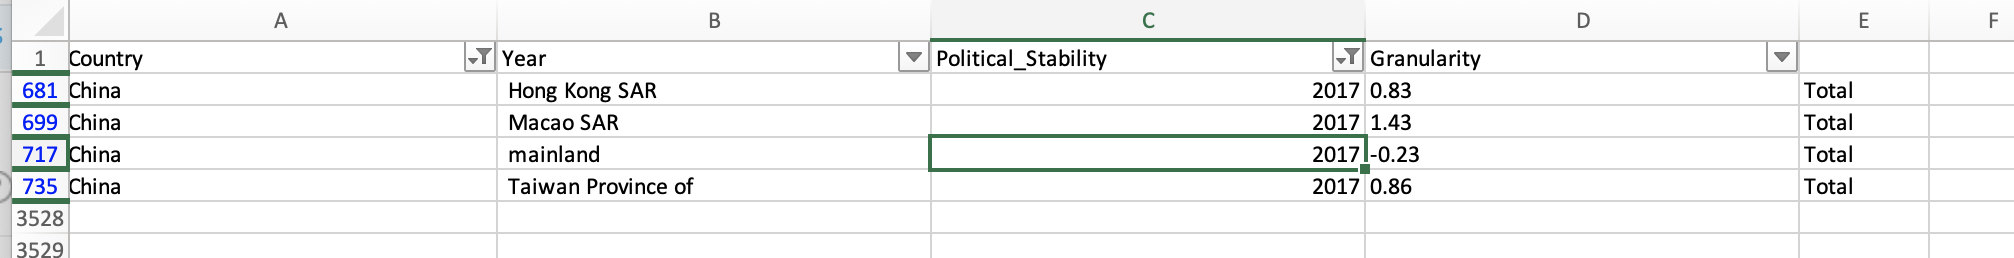

In [75]:
index1 = df_etude_marche[df_etude_marche["Zone"].str.contains("Chine, continentale")].index[0]

df_etude_marche.loc[index1, 'Stabilité politique'] = -0.23

In [76]:
df_etude_marche[df_etude_marche['True'] == 'left_only']

,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes),Population en 2017 (en millier de personne),Stabilité politique,True
34,"Chine, continentale",576.0,452.0,17518.0,18236.0,1421021.791,-0.23,left_only
108,Nouvelle-Calédonie,0.0,9.0,11.0,1.0,277.150,0.28,left_only
120,Polynésie française,0.0,15.0,13.0,1.0,276.102,0.28,left_only


On va maintenant supprimer les lignes correspondant au pays qui n'ont pas de données sur la disponibilité alimentaire et supprimer la colonne de test

In [77]:
# On garde que les lignes complètes, et on supprime la colonne de test `True`
df_etude_marche = df_etude_marche.loc[(df_etude_marche['True'] == 'both') | (df_etude_marche['True'] == 'left_only'), :]
df_etude_marche.drop(columns= 'True', inplace = True)

df_etude_marche.head()

,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes),Population en 2017 (en millier de personne),Stabilité politique
0,Afghanistan,0.0,29.0,55.0,28.0,36296.113,-2.80
1,Afrique du Sud,63.0,514.0,2035.0,1667.0,57009.756,-0.28
2,Albanie,0.0,38.0,47.0,13.0,2884.169,0.38
3,Algérie,0.0,2.0,264.0,275.0,41389.189,-0.92
4,Allemagne,646.0,842.0,1609.0,1514.0,82658.409,0.59


## 2.3 - Ajout du code ISO 3

In [78]:
df_etude_marche = df_etude_marche.merge(df_iso3, how='left', on= 'Zone')

In [79]:
df_etude_marche

,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes),Population en 2017 (en millier de personne),Stabilité politique,Code ISO3
0,Afghanistan,0.0,29.0,55.0,28.0,36296.113,-2.80,AFG
1,Afrique du Sud,63.0,514.0,2035.0,1667.0,57009.756,-0.28,ZAF
2,Albanie,0.0,38.0,47.0,13.0,2884.169,0.38,ALB
3,Algérie,0.0,2.0,264.0,275.0,41389.189,-0.92,DZA
4,Allemagne,646.0,842.0,1609.0,1514.0,82658.409,0.59,DEU
...,...,...,...,...,...,...,...,...
167,Émirats arabes unis,94.0,433.0,412.0,48.0,9487.203,0.62,ARE
168,Équateur,0.0,0.0,324.0,340.0,16785.361,-0.07,ECU
169,États-Unis d'Amérique,3692.0,123.0,18100.0,21914.0,325084.756,0.29,USA
170,Éthiopie,0.0,1.0,14.0,14.0,106399.924,-1.68,ETH


On a juste ajouter le code ISO à chaque pays.

## 2.4 - Ajout du score sur facilité du business

In [80]:
df_etude_marche = df_etude_marche.merge(df_doing_business, how='left', on= 'Code ISO3')

In [81]:
df_etude_marche

,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes),Population en 2017 (en millier de personne),Stabilité politique,Code ISO3,Facilité du Business
0,Afghanistan,0.0,29.0,55.0,28.0,36296.113,-2.80,AFG,38.9
1,Afrique du Sud,63.0,514.0,2035.0,1667.0,57009.756,-0.28,ZAF,65.4
2,Albanie,0.0,38.0,47.0,13.0,2884.169,0.38,ALB,64.2
3,Algérie,0.0,2.0,264.0,275.0,41389.189,-0.92,DZA,46.1
4,Allemagne,646.0,842.0,1609.0,1514.0,82658.409,0.59,DEU,79.6
...,...,...,...,...,...,...,...,...,...
167,Émirats arabes unis,94.0,433.0,412.0,48.0,9487.203,0.62,ARE,77.4
168,Équateur,0.0,0.0,324.0,340.0,16785.361,-0.07,ECU,57.5
169,États-Unis d'Amérique,3692.0,123.0,18100.0,21914.0,325084.756,0.29,USA,83.6
170,Éthiopie,0.0,1.0,14.0,14.0,106399.924,-1.68,ETH,44.1


On regarde si l'on a des valeurs vides sur la facilité du business

In [82]:
df_etude_marche[df_etude_marche['Facilité du Business'].isna()]

,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes),Population en 2017 (en millier de personne),Stabilité politique,Code ISO3,Facilité du Business
32,Chine - RAS de Macao,0.0,23.0,21.0,3.0,622.585,1.43,MAC,NaN
34,"Chine, continentale",576.0,452.0,17518.0,18236.0,1421021.791,-0.23,F41,NaN
40,Cuba,0.0,312.0,269.0,29.0,11339.254,0.65,CUB,NaN
108,Nouvelle-Calédonie,0.0,9.0,11.0,1.0,277.150,0.28,NCL,NaN
120,Polynésie française,0.0,15.0,13.0,1.0,276.102,0.28,PYF,NaN
131,République populaire démocratique de Corée,0.0,0.0,41.0,43.0,25429.825,-0.50,PRK,NaN
156,Turkménistan,0.0,9.0,26.0,20.0,5757.667,-0.13,TKM,NaN


Si l'on regarde la Chine continentale, on peut voir que le code ISO trois est bizarre, normalement le code ISO3 de la Chine, c'est CHN. On va donc remplacer le code et remplacer la valeur de la facilité du business en regardant ce que l'on a pour l'ISO3

In [83]:
# Valeur de la facilité du business pour la chine
df_doing_business[df_doing_business['Code ISO3'] == 'CHN']

,Code ISO3,Facilité du Business
34,CHN,64.6


In [84]:
index1 = df_etude_marche[df_etude_marche["Zone"].str.contains("Chine, continentale")].index[0]

df_etude_marche.loc[index1, 'Code ISO3'] = 'CHN'

df_etude_marche.loc[index1, 'Facilité du Business'] = df_doing_business[df_doing_business['Code ISO3'] == 'CHN']['Facilité du Business'].values[0]

On va s'intéresser au cas de la Corée. La valeur manquante, c'est celle de la Corée-du-nord où je pense que la facilité du business est faible.

In [85]:
df_etude_marche[df_etude_marche['Zone'].str.contains("Corée")]

,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes),Population en 2017 (en millier de personne),Stabilité politique,Code ISO3,Facilité du Business
127,République de Corée,6.0,137.0,854.0,838.0,51096.415,0.39,KOR,84.0
131,République populaire démocratique de Corée,0.0,0.0,41.0,43.0,25429.825,-0.50,PRK,NaN


Il est difficile de faire des affaires avec la Corée du Nord, car c'est très réglementé par les Nations unies. Voici un extrait du règlement du conseil UE. https://eur-lex.europa.eu/legal-content/FR/TXT/?uri=uriserv:OJ.L_.2018.055.01.0001.01.FRA&toc=OJ:L:2018:055:TOC

On va donc supprimer cette ligne

In [86]:
index1 = df_etude_marche[df_etude_marche["Zone"].str.contains("République populaire démocratique de Corée")].index[0]

df_etude_marche.drop(index = index1, inplace= True)

Pour la Nouvelle-Calédonie et la Polynésie française, on va faire comme précédemment, c'est-à-dire, on va récupérer la valeur de la France pour remplacer dans le jeu de données.

In [87]:
index1 = df_etude_marche[df_etude_marche["Zone"].str.contains("Nouvelle-Calédonie")].index[0]
index2 = df_etude_marche[df_etude_marche["Zone"].str.contains("Polynésie française")].index[0]

df_etude_marche.loc[(index1, index2), 'Facilité du Business'] = df_etude_marche[df_etude_marche["Zone"].str.contains("France")]['Facilité du Business'].values[0]

Il nous reste trois pays à traiter : Macao, Cuba, et le Turkménistan. Pour ce pays, on ne dispose pas de valeur sur la facilité du business. Ce que l'on va faire, on va prendre la valeur moyenne de notre jeu de données pour mettre cette valeur sur ce pays.

In [88]:
df_etude_marche[df_etude_marche['Facilité du Business'].isna()]

,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes),Population en 2017 (en millier de personne),Stabilité politique,Code ISO3,Facilité du Business
32,Chine - RAS de Macao,0.0,23.0,21.0,3.0,622.585,1.43,MAC,NaN
40,Cuba,0.0,312.0,269.0,29.0,11339.254,0.65,CUB,NaN
156,Turkménistan,0.0,9.0,26.0,20.0,5757.667,-0.13,TKM,NaN


In [89]:
index1 = df_etude_marche[df_etude_marche["Zone"].str.contains("Macao")].index[0]
index2 = df_etude_marche[df_etude_marche["Zone"].str.contains("Cuba")].index[0]
index3 = df_etude_marche[df_etude_marche["Zone"].str.contains("Turkménistan")].index[0]


df_etude_marche.loc[(index1, index2, index3), 'Facilité du Business'] = round(
    df_doing_business['Facilité du Business'].mean(),1)

On regarde maintenant s'il reste des valeurs ville dans notre jeu de données.

In [90]:
df_etude_marche[df_etude_marche['Facilité du Business'].isna()]

,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes),Population en 2017 (en millier de personne),Stabilité politique,Code ISO3,Facilité du Business


On peut maintenant continuer à construire notre dataframe.

## 2.5 - Ajout du paramètre distance

In [91]:
df_etude_marche = df_etude_marche.merge(df_distance, how='left', on= 'Code ISO3')

In [92]:
df_etude_marche

,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes),Population en 2017 (en millier de personne),Stabilité politique,Code ISO3,Facilité du Business,dist
0,Afghanistan,0.0,29.0,55.0,28.0,36296.113,-2.80,AFG,38.9,5590.3810
1,Afrique du Sud,63.0,514.0,2035.0,1667.0,57009.756,-0.28,ZAF,65.4,9353.5520
2,Albanie,0.0,38.0,47.0,13.0,2884.169,0.38,ALB,64.2,1603.5340
3,Algérie,0.0,2.0,264.0,275.0,41389.189,-0.92,DZA,46.1,1340.3900
4,Allemagne,646.0,842.0,1609.0,1514.0,82658.409,0.59,DEU,79.6,439.8984
...,...,...,...,...,...,...,...,...,...,...
166,Émirats arabes unis,94.0,433.0,412.0,48.0,9487.203,0.62,ARE,77.4,5249.5350
167,Équateur,0.0,0.0,324.0,340.0,16785.361,-0.07,ECU,57.5,9367.0980
168,États-Unis d'Amérique,3692.0,123.0,18100.0,21914.0,325084.756,0.29,USA,83.6,5838.1570
169,Éthiopie,0.0,1.0,14.0,14.0,106399.924,-1.68,ETH,44.1,5582.5020


- On regarde s'il manque des valeurs

In [93]:
df_etude_marche[df_etude_marche['dist'].isna()]

,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes),Population en 2017 (en millier de personne),Stabilité politique,Code ISO3,Facilité du Business,dist
100,Monténégro,0.0,8.0,10.0,4.0,627.563,-0.06,MNE,71.2,NaN
123,Roumanie,69.0,146.0,381.0,392.0,19653.969,0.06,ROU,72.9,NaN
137,Serbie,7.0,12.0,90.0,85.0,8829.628,0.09,SRB,73.3,NaN
151,Timor-Leste,0.0,11.0,5.0,1.0,1243.258,0.07,TLS,38.2,NaN


Il manque 4 valeurs.

Pour la Roumanie, on a encore un problème sur le code ISO.  Nous avons le code ROU que c'est le code ROM. On va récupérer dans le dataframe distance la valeur.

In [94]:
df_distance[df_distance['Code ISO3']=='ROM']['dist']

15177 1875.018
Name: dist, dtype: float64

In [95]:
index1 = df_etude_marche[df_etude_marche["Zone"].str.contains("Roumanie")].index[0]

df_etude_marche.loc[index1, 'dist'] = df_distance[df_distance['Code ISO3']=='ROM']['dist'].values[0]

Pour le Monténégro et la Serbie, c'est anciennement la Yougoslavie . On va donc prendre le code ISO de la Yougoslavie, c'est-à-dire, YUG et mettre la valeur aux deux pays.

In [96]:
index1 = df_etude_marche[df_etude_marche["Zone"].str.contains("Monténégro")].index[0]
index2 = df_etude_marche[df_etude_marche["Zone"].str.contains("Serbie")].index[0]

df_etude_marche.loc[(index1, index2), 'dist'] = df_distance[df_distance['Code ISO3']=='YUG']['dist'].index[0]

Pour le Timor-leste, on a encore un problème sur le code ISO3.

In [97]:
index1 = df_etude_marche[df_etude_marche["Zone"].str.contains("Timor-Leste")].index[0]

df_etude_marche.loc[index1, 'dist'] = df_distance[df_distance['Code ISO3']=='TMP']['dist'].index[0]

On va pouvoir maintenant, vérifier une dernière fois que l'on est sans valeur manquante dans notre jeu de données

In [98]:
df_etude_marche[df_etude_marche['dist'].isna()]

,Zone,Exportations (en millier de tonnes),Importations (en millier de tonnes),Nourriture (en millier de tonnes),Production(en millier de tonnes),Population en 2017 (en millier de personne),Stabilité politique,Code ISO3,Facilité du Business,dist


Maintenant, on peut faire l'analyse exploratoire. 

# 3 - Relations entre les variables

Pour étudier la relation entre ces variables, on va utiliser la méthode de l'ACP. Ça va nous permettre de simplifier  le nombre de variables et de voir la relation entre elle.

## 3.1 - Paramétrage de l'ACP
Nous allons reprendre notre dataframe précédent et le préparer pour réaliser l'ACP.

On commence par mettre dans une matrice de valeur notée X, seulement les valeurs numériques de notre dataframe précédent.

In [99]:
# On sélectionne seulement les données de type numérique
X = df_etude_marche.select_dtypes(exclude= ['object']).values


X[:5]

array([[ 0.0000000e+00, 2.9000000e+01, 5.5000000e+01, 2.8000000e+01,
 3.6296113e+04, -2.8000000e+00, 3.8900000e+01, 5.5903810e+03],
 [ 6.3000000e+01, 5.1400000e+02, 2.0350000e+03, 1.6670000e+03,
 5.7009756e+04, -2.8000000e-01, 6.5400000e+01, 9.3535520e+03],
 [ 0.0000000e+00, 3.8000000e+01, 4.7000000e+01, 1.3000000e+01,
 2.8841690e+03, 3.8000000e-01, 6.4200000e+01, 1.6035340e+03],
 [ 0.0000000e+00, 2.0000000e+00, 2.6400000e+02, 2.7500000e+02,
 4.1389189e+04, -9.2000000e-01, 4.6100000e+01, 1.3403900e+03],
 [ 6.4600000e+02, 8.4200000e+02, 1.6090000e+03, 1.5140000e+03,
 8.2658409e+04, 5.9000000e-01, 7.9600000e+01, 4.3989840e+02]])

On récupère dans une variable `pays`, la liste des pays.

In [100]:
pays = df_etude_marche['Zone'].values
pays[:5]

array(['Afghanistan', 'Afrique du Sud', 'Albanie', 'Algérie', 'Allemagne'],
 dtype=object)

On fait de mêmes pour le nom des variables numériques.

In [101]:
variables = df_etude_marche.select_dtypes(exclude= ['object']).columns
variables

Index(['Exportations (en millier de tonnes)',
       'Importations (en millier de tonnes)',
       'Nourriture (en millier de tonnes)', 'Production(en millier de tonnes)',
       'Population en 2017 (en millier de personne)', 'Stabilité politique',
       'Facilité du Business', 'dist'],
      dtype='object')

On va centrer et réduire les données pour avoir une moyenne à 0 et un écart type de 1 pour chaque variable.

In [102]:
#On initialise le scaler
scaler = StandardScaler()

# on centre et reduit les données
X_scaled = scaler.fit_transform(X)
X_scaled[:5]

array([[-0.2278546 , -0.32313214, -0.28143806, -0.27657061, -0.04343106,
 -3.06893022, -1.75855216, -0.15279745],
 [-0.09029912, 2.2885981 , 0.6504684 , 0.38593799, 0.09190103,
 -0.24785549, 0.26709073, 0.776793 ],
 [-0.2278546 , -0.27466704, -0.28520334, -0.28263384, -0.26172718,
 0.49099741, 0.1753635 , -1.13764105],
 [-0.2278546 , -0.46852743, -0.18307016, -0.17672947, -0.01015557,
 -0.96431892, -1.20818881, -1.20264372],
 [ 1.18263497, 4.05488164, 0.44996731, 0.32409307, 0.25947588,
 0.72608697, 1.35252955, -1.42508601]])

On vérifie que l'on a bien 0 en moyenne et 1 en écart type

In [103]:
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6,7
mean,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


On a bien nos données qui sont centrées et réduites. 

## 3.2 détermination du nombre de composante
On commence par prendre arbitrairement 6 composantes.

In [104]:
n_composantes = 6

Nous créons notre ACP

In [105]:
acp = PCA(n_components= n_composantes)

In [106]:
acp.fit(X_scaled)

PCA(n_components=6)

Nous définissons le pourcentage d'inertie pour chaque rang.

In [107]:
scree = (acp.explained_variance_ratio_*100).round(2)
scree

array([39.34, 21.14, 13.52, 10.85, 8.81, 4.31])

On calcule la somme cumulée du pourcentage d'inertie

In [108]:
scree_cum = scree.cumsum().round()
scree_cum

array([39., 60., 74., 85., 94., 98.])

### Création de l'éboulis des valeurs

On crée un éboulis de valeur, afin de pouvoir déterminer le nombre de rangs que l'on va utiliser pour notre ACP et nos plans factoriels.

In [109]:
# Liste des rangs
x_list = range(1, n_composantes + 1)


#Création du graphique
fig = go.Figure()

fig.add_bar(x=list(x_list), y=scree, name= "Inertie")
fig.add_scatter(x=list(x_list), y=scree_cum, mode='lines+markers', 
                marker={'color': 'red'}, 
                line={'color': 'red'}, 
                name= "Somme cumulée")



fig.update_layout(xaxis_title='Rang de l\'axe d\'inertie', 
                  yaxis_title='Pourcentage d\'inertie', 
                  title='Eboulis des valeurs propres',
                  height = 600)

fig.show()

On va regarder les 4 premiers axes d'inertie ce qui va nous permettre d'avoir plus de 85 % d'inertie cumulée. 

## 3.3 Cercles de corrélations

On va créer différents cercles de corrélation en fonction de différents plans factoriels.

In [110]:
cercle_correlation(acp= acp, rang_1=1, rang_2= 2)

On retrouve une corrélation presque parfaite entre la nourriture et la production de nourriture qui est fortement corrélée à l'axe F1. On a aussi une corrélation avec l'exportation et également la population. Cet axe représente les besoins en nourriture de la population, plus on a une grande population, plus on va avoir des besoins que ce soit en production.

On voit qu'il y a une grande corrélation avec la stabilité politique et la facilité du business sur l'axe F2. Cette corrélation est inversée, c'est-à-dire plus la valeur de l'axe F2 augmente moins, il est facile de faire du business. Cet axe F2 pourrait représenter la difficulté à faire du business avec les pays. On voit aussi que l'importation est faiblement corrélée à l'axe F2.


In [111]:
cercle_correlation(acp= acp, rang_1=3, rang_2= 4)

Ici, l'axe F3 a l'air, d'être fortement corrélée à la distance entre la France et le pays cible. Tandis que l'axe F4 semble d'être fortement corrélée positivement à l'exportation et négativement à l'importation. Cette taxe F4 pourrait représenter l'importation ou l'exportation du pays. Je trouve cet axe F4 super pertinent pour notre étude.

Si l'on résume, on a :
- F1 qui correspond au besoin en viande de volaille ;
- F2 qui correspond à la difficulté à faire du business ;
- F3 qui correspond à la distance entre la France et le pays cible ;
- F4 qui correspond à un indicateur d'import export ;
  
Nous allons projeter nos données sur ces axes, mais avant, nous rajoutons ces informations dans un dataframe afin d'avoir des graphiques pertinents pour nos projections.

In [112]:
data = {'rang': range(1,7),
        'pourcentage': scree,
        'signification': ['Besoin en viande de volaille', 'Difficulté à faire du business', 'Distance', 'Exportation', '', '']
        }
df_axe_inertie = pd.DataFrame(data)

df_axe_inertie

,rang,pourcentage,signification
0,1,39.34,Besoin en viande de volaille
1,2,21.14,Difficulté à faire du business
2,3,13.52,Distance
3,4,10.85,Exportation
4,5,8.81,
5,6,4.31,


## 3.4 - projection des données sur les axes d'inertie

On crée le DataFrame contenant les données de chaque pays projeté sur les axes d'inertie

In [113]:
X_proj = acp.transform(X_scaled)
X_proj

array([[-7.38983084e-01, 3.12262685e+00, -1.18910550e+00,
 -1.44601607e-01, -7.15144978e-01, 7.74706584e-01],
 [ 1.04626544e+00, -4.75614479e-01, -1.71710202e-01,
 -1.92108233e+00, -1.17729606e+00, 1.51054933e-01],
 [-5.34616580e-01, -5.98052192e-01, -7.33509999e-01,
 5.89772950e-01, 4.99175694e-01, -3.62008693e-01],
 ...,
 [ 1.36289514e+01, 2.98471713e-03, 1.13087125e+00,
 4.06736806e+00, -1.75658995e+00, 1.65649203e-01],
 [-5.48960808e-01, 2.21236020e+00, -6.74625784e-01,
 -9.66085243e-02, -1.66540610e-02, 2.27381187e-01],
 [-7.02963184e-01, 5.06236803e-01, 2.12312701e+00,
 -4.77958037e-01, -5.21891278e-01, 4.96481927e-02]])

In [114]:
projection_acp(X_proj = X_proj, rang_1 = 1, rang_2 = 2)

On peut s'apercevoir que l'on a une grande dispersion sur la difficulté à faire du business, alors que la dispersion sur le besoin en viande de volaille est proche de zéro ou positive.

In [115]:
projection_acp(X_proj = X_proj, rang_1 = 3, rang_2 = 4)

On peut voir que le cadran en bas à gauche est intéressant parce qu'il représente des pays qui ont une valeur d'exploitation négative, c'est-à-dire pas besoin d'importation et qui sont assez proches de nous.

In [116]:
projection_acp_3d(X_proj = X_proj, rang_1 = 1, rang_2 = 2, rang_3= 4)

On peut voir sur ce graphique que l'on a beaucoup de pays regroupés. Il serait peut-être intéressant de définir les clusters que l'on a. À fin de pouvoir se concentrer sur un seul cluster.

# 4 - Export
Maintenant que l'on a fait tout ça, on va pouvoir exporter les dataframe à fin de classifier les données dans un autre Notebook.

In [117]:
# On crée un Dataframe contenant les résultat de l'ACP
df_acp = pd.DataFrame(X_proj)
df_acp = df_acp.assign(Zone=pays)
df_acp = df_acp.rename(columns={0: 'Besoin en viande', 
                                    1: 'Difficulté à faire des affaires', 
                                    2: 'Distance', 
                                    3: 'Exportation'}).drop(columns=[4,5])

df_acp

,Besoin en viande,Difficulté à faire des affaires,Distance,Exportation,Zone
0,-0.738983,3.122627,-1.189105,-0.144602,Afghanistan
1,1.046265,-0.475614,-0.171710,-1.921082,Afrique du Sud
2,-0.534617,-0.598052,-0.733510,0.589773,Albanie
3,-0.559735,1.350289,-1.244908,0.516813,Algérie
4,2.039468,-2.672516,-2.302902,-1.787508,Allemagne
...,...,...,...,...,...
166,0.230081,-1.913928,-0.596028,-1.100927,Émirats arabes unis
167,-0.478484,0.428767,0.809286,-0.000600,Équateur
168,13.628951,0.002985,1.130871,4.067368,États-Unis d'Amérique
169,-0.548961,2.212360,-0.674626,-0.096609,Éthiopie


In [118]:
df_etude_marche.to_csv('df_etude_marche.csv', index= False)

df_acp.to_csv('df_acp.csv', index= False)